# Recommender System on Hotel's Features Dataset


<table align="center">
  <td>
    <a href="https://colab.research.google.com/drive/1nNDW7uDZaCjbUwVV9s6qbkrmeaB6Qaid?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## 1. Importing Libraries, installing Facebook Sent2Vec Model & loading our dataset.
### 1.1. Mounting and importing libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### 1.2. Installing **`Sent2Vec`**

In [3]:
!git clone https://github.com/epfml/sent2vec.git

fatal: destination path 'sent2vec' already exists and is not an empty directory.


In [4]:
current_path = os.path.abspath(os.getcwd())
new_path = os.path.join(current_path, "sent2vec")
os.chdir(new_path)

In [5]:
!make

!pip install --upgrade cython

!python setup.py build_ext

!pip install .

c++ -pthread -std=c++0x -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/shmem_matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/fasttext.cc
c++ -pthread -std=c++0x -O3 -funroll-loops args.o dictionary.o productquantizer.o matrix.o shmem_matrix.o qmatrix.o vector.o model.o utils.o fasttext.o src/main.cc -o fasttext -lrt
Requirement already up-to-date: cython in /usr/local/lib/python3.7/dist-packages (0.29.23)
Compiling src/sent2vec.pyx because it changed.
[1/1] Cythonizing src/sent2vec.pyx
/usr/local/lib/python3.7/di

### 1.3. reading **Hotel's Features Dataset** and do some preprocessing on it

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/hotel_features_dataset.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.head(3)

,name,country,street,region,rating,reviews,amenities,rooms,types,price,official_description
0,WH Hotel,Lebanon,Lyon Street Hamra Emille Edde,NaN,4.0,"{'Excellent': 104, 'Good': 102, 'Average': 51,...","Free High Speed Internet (WiFi),Free breakfast...","Air conditioning,Fireplace,Housekeeping,Room s...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
1,Le Patio Boutique Hotel,Lebanon,"1144 Marfaa, Uruguay Street Solidere",NaN,4.5,"{'Excellent': 213, 'Good': 78, 'Average': 31, ...","Paid private parking nearby,Free High Speed In...","Air conditioning,Housekeeping,Room service,Saf...","Non-smoking rooms,Suites,Family rooms,Smoking ...",121.0,NaN
2,Riviera Hotel Beirut,Lebanon,"Avenue De Paris, Corniche El Manara Riad El Solh",NaN,3.5,"{'Excellent': 90, 'Good': 101, 'Average': 69, ...","Valet parking,Free High Speed Internet (WiFi),...","Air conditioning,Private balcony,Room service,...","Ocean view,Pool view,Non-smoking rooms,Suites,...",NaN,NaN


In [5]:
wanted_columns = ['name', 'country', 'rating', 'amenities', 'rooms', 'types']
df = df[wanted_columns]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62617 entries, 0 to 73073
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       62617 non-null  object 
 1   country    62617 non-null  object 
 2   rating     62617 non-null  float64
 3   amenities  62617 non-null  object 
 4   rooms      62617 non-null  object 
 5   types      62617 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.3+ MB


In [6]:
features = df['amenities'] + ',' +df['rooms']+ ',' +df['types']

In [11]:
def preprocess_text(sen):
    sentence = re.compile(r'<[^>]+>').sub('', sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

In [12]:
cleaned_features = []
for feature in features:
  cleaned_features.append(preprocess_text(feature).lower())

## 2. Building the recommended
### 2.1. Use Sent2vec model to convert our features to embeddings.

In [13]:
import sent2vec
model = sent2vec.Sent2vecModel()
model.load_model('/content/gdrive/MyDrive/wiki_unigrams.bin', inference_mode = True)

In [14]:
# emb = model.embed_sentence("once upon a time .") 
embs = model.embed_sentences(cleaned_features)

In [15]:
embs.shape

(62617, 600)

### 2.2. Calculate the similarities between hotels using Cosine Similarly.

In [18]:
def most_similar(idx, similarity_matrix, count):
    print (f'Similar Hotels to {features_df.iloc[idx]["name"]}:')
    similar_ix=np.argsort(similarity_matrix[idx])[::-1]
    for ix in similar_ix[:count+1]:
        if ix != idx:
            print (f'Hotel Name : {features_df.iloc[ix]["name"]} Similarity: {similarity_matrix[idx][ix]}')

In [19]:
pairwise_similarities =cosine_similarity(embs[:40000])

In [20]:
most_similar(5, pairwise_similarities, 6)

Similar Hotels to The Mayflower Hotel:
Hotel Name : Catina Hotel Similarity: 0.9822630882263184
Hotel Name : Erboy Hotel Similarity: 0.9741029739379883
Hotel Name : Treebo Trend Singh Sons Similarity: 0.9699388742446899
Hotel Name : Villa Hue Similarity: 0.9699212312698364
Hotel Name : Hotel Le Carnot Similarity: 0.9684607982635498
Hotel Name : Hotel Sagar Plaza Similarity: 0.9671428203582764


## 3. Dimensionality reduction and Visualizations

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [22]:
print(pca.components_)

[[ 0.02921716  0.01130726  0.02842636 ... -0.0282056   0.01824681
  -0.04077467]
 [-0.04618743 -0.0900166  -0.03437936 ...  0.05728804  0.01641948
   0.00887636]]


In [23]:
print(pca.explained_variance_)

[1.177331 0.510407]


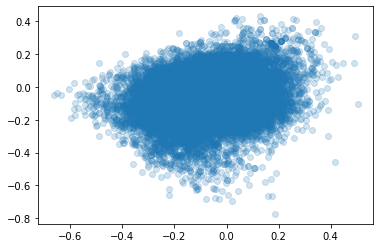

In [24]:
plt.scatter(embs[:, 0], embs[:, 1], alpha=0.2)

In [25]:
pca = PCA(n_components=1)
#clf = PCA(0.95) # keep 95% of variance
pca.fit(embs)
embs_pca = pca.transform(embs)
print("original shape:   ", embs.shape)
print("transformed shape:", embs_pca.shape)

original shape:    (62617, 600)
transformed shape: (62617, 1)


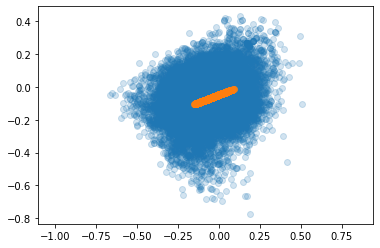

In [26]:
embs_new = pca.inverse_transform(embs_pca)
plt.scatter(embs[:, 0], embs[:, 1], alpha=0.2)
plt.scatter(embs_new[:, 0], embs_new[:, 1], alpha=0.8)
plt.axis('equal');

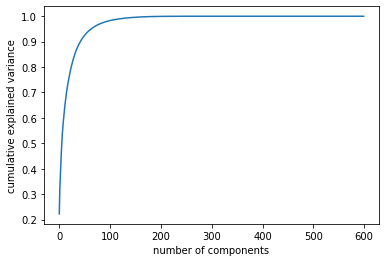

In [27]:
pca = PCA().fit(embs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

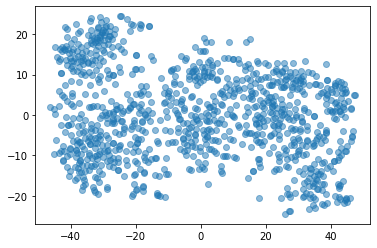

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(embs[:1000])
plt.scatter(tsne[:,0],tsne[:,1],alpha=0.5)

## 4. Features Selection

In [8]:
features_df = pd.DataFrame({'name': df.name, 'features': features})

In [9]:
features_df.head()

,name,features
0,WH Hotel,"Free High Speed Internet (WiFi),Free breakfast..."
1,Le Patio Boutique Hotel,"Paid private parking nearby,Free High Speed In..."
2,Riviera Hotel Beirut,"Valet parking,Free High Speed Internet (WiFi),..."
3,Le Bristol Beyrouth,"Free High Speed Internet (WiFi),Pool,Fitness C..."
4,Golden Tulip Midtown Hotel And Suites,"Free parking,Free High Speed Internet (WiFi),P..."


In [10]:
oh_df = features_df['features'].str.get_dummies(sep=',') #one hot encoded dataframe

In [11]:
oh_df.head(3)

,DVDs,music for children,24-hour check-in,24-hour front desk,24-hour security,ATM on site,Additional bathroom,Adult pool,Adults only,Aerobics,Aerobics offsite,Air conditioning,Air purifier,Airport transportation,Allergy-free room,Archery,Archery offsite,BBQ facilities,Babysitting,Badminton,Baggage storage,Banquet room,Bar / lounge,Bath / shower,Bathrobes,Beach,Bicycle rental,Bicycle tours,Bicycles available,Bidet,Billiards,Blackout curtains,Board games / puzzles,Boating,Body wrap,Books,Bottled water,Bowling,Bowling offsite,Breakfast available,...,hotel_amenity_smoking_rooms_available,hotel_amenity_snack_bar,hotel_amenity_snorkeling,hotel_amenity_sofa,hotel_amenity_solarium,hotel_amenity_soundproof_rooms,hotel_amenity_spa,hotel_amenity_special_diet_menus,hotel_amenity_steam_room,hotel_amenity_suites,hotel_amenity_sun_deck,hotel_amenity_sun_loungers_beach_chairs,hotel_amenity_sun_terrace,hotel_amenity_sun_umbrellas,hotel_amenity_swimming_pool_toys,hotel_amenity_swimup_bar,hotel_amenity_table_tennis,hotel_amenity_taxi_service,hotel_amenity_telephone,hotel_amenity_tennis_court,hotel_amenity_tile_marble_floor,hotel_amenity_umbrella,hotel_amenity_vending_machine,hotel_amenity_vip_room_facilities,hotel_amenity_wake_up_service_alarm_clock,hotel_amenity_walk_in_shower,hotel_amenity_walking_tours,hotel_amenity_wardrobe_closet,hotel_amenity_water_park_offsite,hotel_amenity_water_sport_equipment_rentals,hotel_amenity_waxing_services,hotel_amenity_whirlpool_bathtub,hotel_amenity_wifi,hotel_amenity_windsurfing,hotel_amenity_wine_champagne,hotel_amenity_yoga_classes,hotel_amenity_yoga_room,iPod docking station,tags_category_tag_free_airport_transportation_1,tags_category_tag_non_smoking_rooms_1
0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn.feature_selection import VarianceThreshold
sel_var = VarianceThreshold(threshold=(.7 * (1 - .7)))
sel_var.fit(oh_df.values)
selected_features = sel_var.transform(oh_df.values)

[False False False  True False False False False False False False False
 False  True False False False False False False  True False  True  True
 False False False False False False False False False False False False
 False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False  True False False False False False False False False False
  True False False False False False False False  True False False False
 False  True False  True False False False False False False False False
 False  True False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False  True False False False False False False False False
 False False False False False False False False  T

([], <a list of 0 Text major ticklabel objects>)

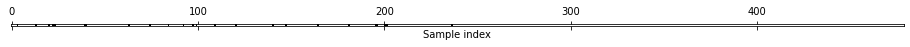

In [15]:
import matplotlib.pyplot as plt
mask = sel_var.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())

In [17]:
selected_features = []
for feature, support in zip(oh_df.columns, mask):
  if support:
    selected_features.append(feature)

In [18]:
selected_features

['24-hour front desk',
 'Airport transportation',
 'Baggage storage',
 'Bar / lounge',
 'Bath / shower',
 'Breakfast available',
 'Breakfast buffet',
 'Concierge',
 'Dry cleaning',
 'Family rooms',
 'Flatscreen TV',
 'Free breakfast',
 'Free parking',
 'Hair dryer',
 'Housekeeping',
 'Laundry service',
 'Meeting rooms',
 'Outdoor pool',
 'Pool',
 'Refrigerator',
 'Restaurant',
 'Room service',
 'Safe',
 'Suites']

In [21]:
sf_df = oh_df[selected_features] #selected features dataframe

In [22]:
sf_df.head(3)

,24-hour front desk,Airport transportation,Baggage storage,Bar / lounge,Bath / shower,Breakfast available,Breakfast buffet,Concierge,Dry cleaning,Family rooms,Flatscreen TV,Free breakfast,Free parking,Hair dryer,Housekeeping,Laundry service,Meeting rooms,Outdoor pool,Pool,Refrigerator,Restaurant,Room service,Safe,Suites
0,0,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1
1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,1,0,1,1,0,1,1,1,1
2,0,1,0,1,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,1,0,1


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(sf_df.values)
new_data = pca.transform(sf_df.values)

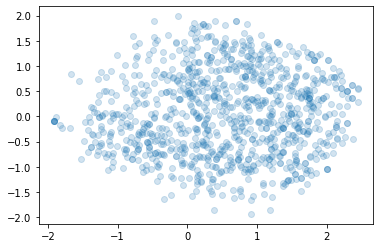

In [34]:
plt.scatter(new_data[:, 0][:1000], new_data[:, 1][:1000], alpha=0.2)

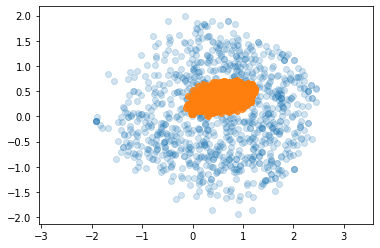

In [36]:
rev_new_data = pca.inverse_transform(new_data)
plt.scatter(new_data[:, 0][:1000], new_data[:, 1][:1000], alpha=0.2)
plt.scatter(rev_new_data[:, 0][:1000], rev_new_data[:, 1][:1000], alpha=0.8)
plt.axis('equal');

In [39]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(new_data)
y_pred = kmeans.predict(new_data)

In [ ]:
from sklearn.cluster import DBSCAN
cl = DBSCAN(eps=0.01).fit(new_data)

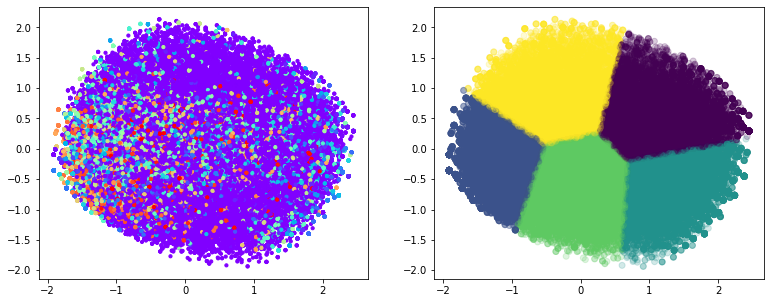

In [50]:
f, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].scatter(new_data[:, 0], new_data[:, 1], c=cl.labels_, s=10, cmap='rainbow');
ax[1].scatter(new_data[:, 0], new_data[:, 1], alpha=0.2, c=y_pred)

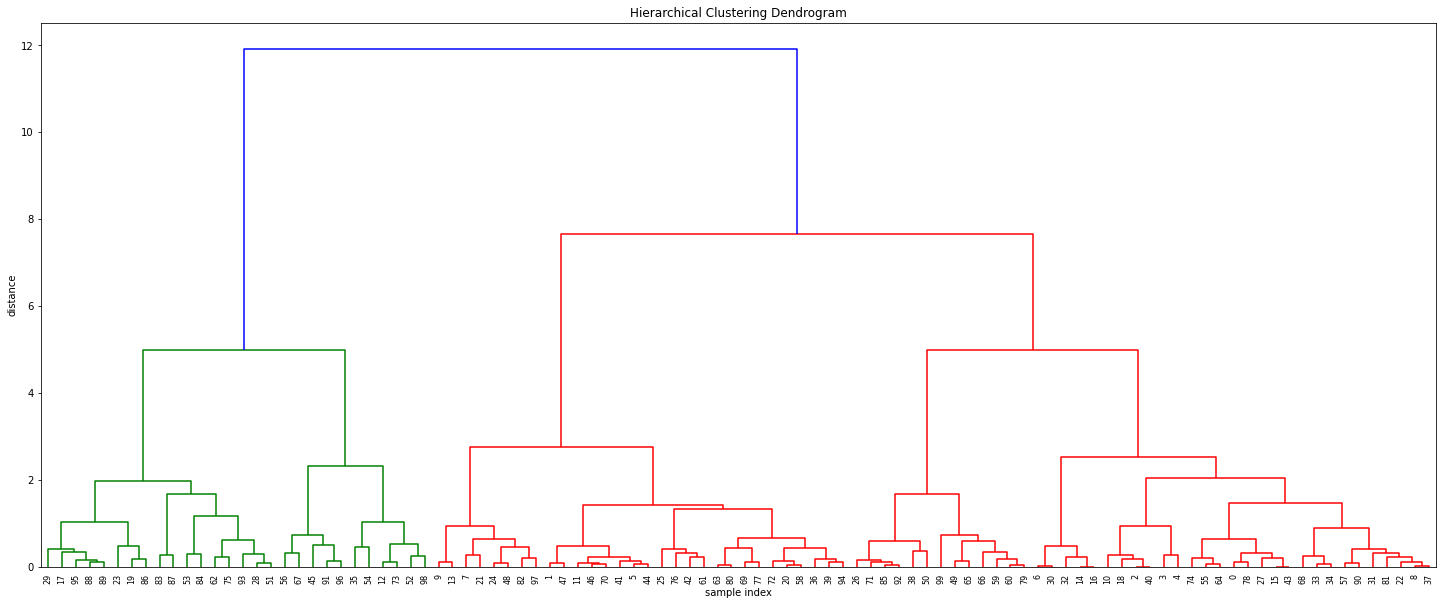

In [53]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import load_iris

X = new_data[:100]

Z = linkage(X, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

dendrogram(Z, leaf_rotation=90., leaf_font_size=8.);
plt.show();
